# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

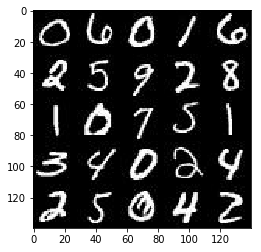

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

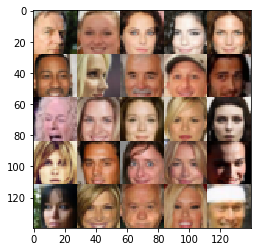

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')

    return inputs_real, inputs_z, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):     
        # Input layer is 28x28x3/1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        drop2 = tf.nn.dropout(x2, keep_prob)
        bn2 = tf.layers.batch_normalization(drop2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        drop3 = tf.nn.dropout(x3, keep_prob)
        bn3 = tf.layers.batch_normalization(drop3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='SAME')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, keep_p=1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha, keep_prob=keep_p)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, keep_prob=keep_p)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(0.5 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, keep_prob):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #tf.reset_default_graph()
    image_dim = data_shape[1:]
    out_channel_dim = data_shape[3]
    
    keep_p = tf.placeholder(tf.float32, name='keep_b')
    input_real, input_z, learn_rate = model_inputs(*image_dim, z_dim=z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim, alpha=0.2, keep_p=keep_p)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            # Train 2 epochs per time
            if epoch_i % 2 == 0:
                resp = input('Train more 2 epochs? [y/n]')
                if resp == 'y':
                    pass
                if resp == 'n':
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)
                    return
    
            for batch_images in get_batches(batch_size):
                step += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Rescale real image input to (-1, 1)
                batch_images = scale(batch_images)

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, keep_p: keep_prob})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, keep_p: keep_prob})
                
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, keep_p: 1.})
                    train_loss_g = g_loss.eval({input_z: batch_z, keep_p: 1.})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if step % 100 == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Train more 2 epochs? [y/n]y
Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 1.2545
Epoch 1/1... Discriminator Loss: 0.2970... Generator Loss: 3.7750
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 2.2624
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 6.1207
Epoch 1/1... Discriminator Loss: 2.6549... Generator Loss: 0.2031
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.5086


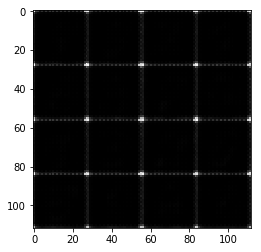

Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 1.4583
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.5952... Generator Loss: 2.5223
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 1.2322
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 1.2966
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.5708
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 1.6096


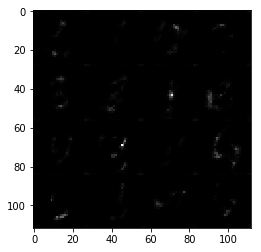

Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.1676
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.5360
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 1.3755
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.2550
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.5900
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.6769


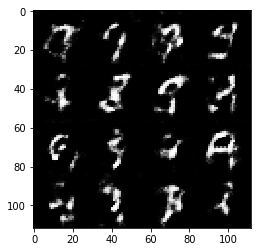

Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 1.6059
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 2.1559
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 2.1117
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.5645


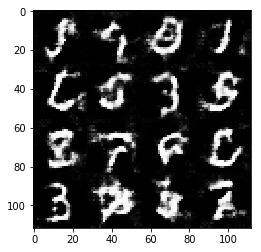

Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.4446
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.3353
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 1.5612
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 1.2469
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.4324


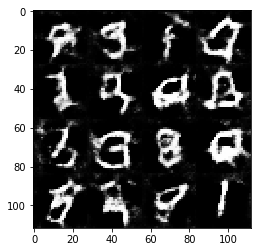

Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 1.5363
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.4414
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.5404
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.3463
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.6367


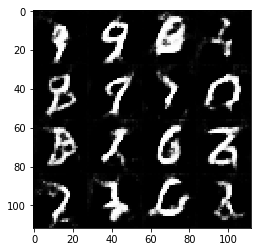

Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.1472
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.7546
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.4300


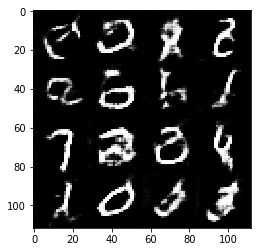

Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 1.6341
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 1.5088
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.6208
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.5466
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.6933
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.5865
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 1.5566
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 0.8620


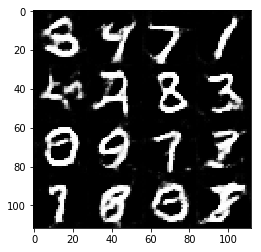

Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.3476
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.5195
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.3478
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.3806
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 0.6533


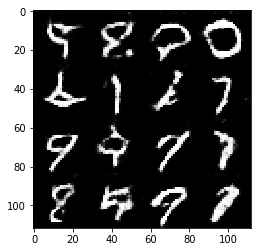

Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 1.6157
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 0.7124


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
keep_prob = 1.0

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, keep_prob)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Train more 2 epochs? [y/n]y
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 1.9474
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 3.6562
Epoch 1/1... Discriminator Loss: 2.8428... Generator Loss: 0.2016
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 3.1096
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 2.4735
Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 2.8909
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 1.4782


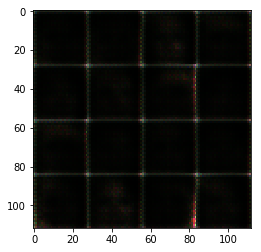

Epoch 1/1... Discriminator Loss: 3.3250... Generator Loss: 0.0986
Epoch 1/1... Discriminator Loss: 0.3152... Generator Loss: 2.2392
Epoch 1/1... Discriminator Loss: 0.1893... Generator Loss: 4.5503
Epoch 1/1... Discriminator Loss: 0.2427... Generator Loss: 2.0089
Epoch 1/1... Discriminator Loss: 1.7798... Generator Loss: 0.3000
Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 4.1417
Epoch 1/1... Discriminator Loss: 0.2024... Generator Loss: 3.6507
Epoch 1/1... Discriminator Loss: 0.3213... Generator Loss: 1.7486
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 0.2402... Generator Loss: 2.6419


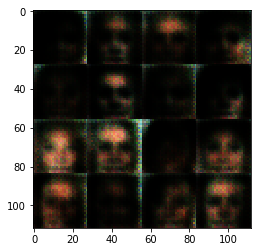

Epoch 1/1... Discriminator Loss: 1.6486... Generator Loss: 0.4202
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 0.3534... Generator Loss: 2.0122
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.8344
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.7279... Generator Loss: 0.2833
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 1.1312


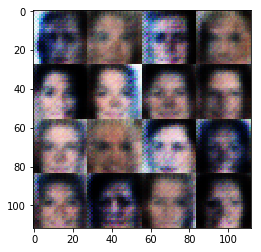

Epoch 1/1... Discriminator Loss: 2.5094... Generator Loss: 0.1456
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.5174
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.6785
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 0.7476... Generator Loss: 2.3136
Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.2452
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 2.4032


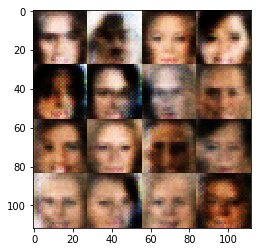

Epoch 1/1... Discriminator Loss: 0.2773... Generator Loss: 2.7300
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 0.6151... Generator Loss: 3.2473
Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 1.8247
Epoch 1/1... Discriminator Loss: 2.2093... Generator Loss: 0.1511
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 3.2570
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 0.2868
Epoch 1/1... Discriminator Loss: 1.6813... Generator Loss: 0.4201
Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 1.4433


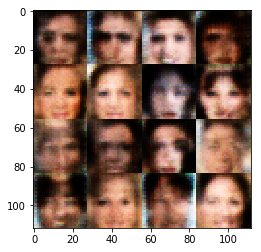

Epoch 1/1... Discriminator Loss: 2.1925... Generator Loss: 0.1605
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 4.4573
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 2.4598
Epoch 1/1... Discriminator Loss: 1.7969... Generator Loss: 0.2430
Epoch 1/1... Discriminator Loss: 1.7684... Generator Loss: 4.1111
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 2.1973... Generator Loss: 0.1560
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.8803


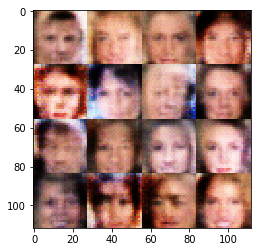

Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 1.6216... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.6187... Generator Loss: 0.3097
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.6500... Generator Loss: 0.3571
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 3.5116
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.5373


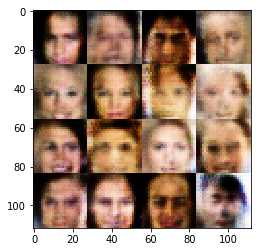

Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 5.4451
Epoch 1/1... Discriminator Loss: 1.6398... Generator Loss: 0.3001
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.6322... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 0.4846... Generator Loss: 1.2176
Epoch 1/1... Discriminator Loss: 1.7178... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.4491


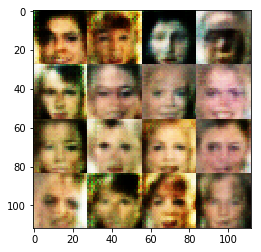

Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 3.6674
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 3.5007... Generator Loss: 1.7797
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.9262
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 0.4195... Generator Loss: 2.5850


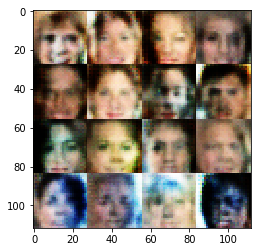

Epoch 1/1... Discriminator Loss: 1.7266... Generator Loss: 0.3015
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.3381


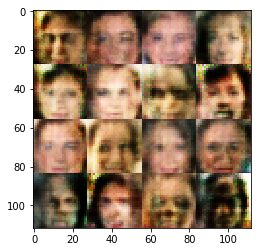

Epoch 1/1... Discriminator Loss: 1.7251... Generator Loss: 0.3048
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 1.5423
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 2.8043
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 0.5698... Generator Loss: 1.8450
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 1.5821
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 1.9122
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7528


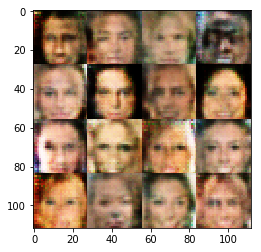

Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.6751... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 0.2659... Generator Loss: 3.4242
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 0.7339


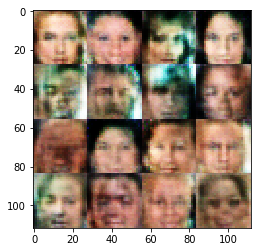

Epoch 1/1... Discriminator Loss: 0.2408... Generator Loss: 2.8831
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.8204
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 1.9445
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 3.4361
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 2.5155
Epoch 1/1... Discriminator Loss: 0.1523... Generator Loss: 5.1921
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 1.4802
Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.7584


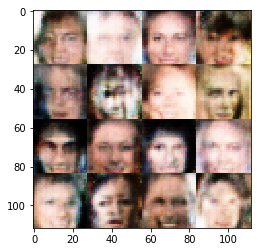

Epoch 1/1... Discriminator Loss: 1.5591... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.8513


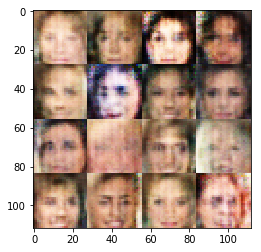

Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6954


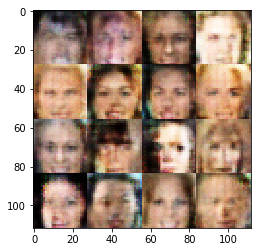

Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.7389


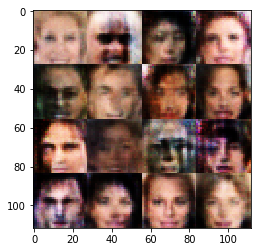

Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.7753
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.7263


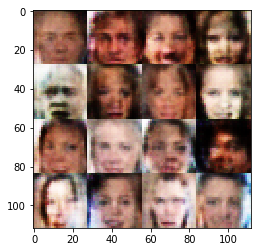

Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.3469
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 3.0679
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 1.2739


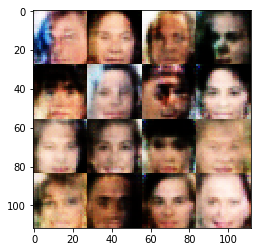

Epoch 1/1... Discriminator Loss: 1.5842... Generator Loss: 0.4133
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 4.0067
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.7972
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.3568


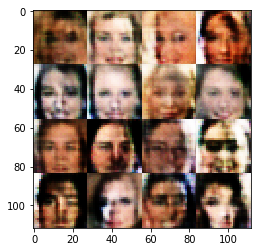

Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.4706
Epoch 1/1... Discriminator Loss: 1.9190... Generator Loss: 2.9691
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 2.9697
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 4.8888
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 3.0329


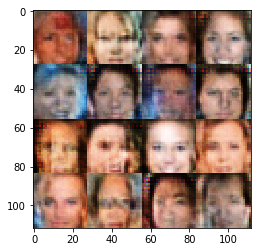

Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.4095
Epoch 1/1... Discriminator Loss: 0.2592... Generator Loss: 1.8661
Epoch 1/1... Discriminator Loss: 0.1812... Generator Loss: 2.2454
Epoch 1/1... Discriminator Loss: 0.4099... Generator Loss: 1.8449
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 0.4629... Generator Loss: 1.4139
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.3967


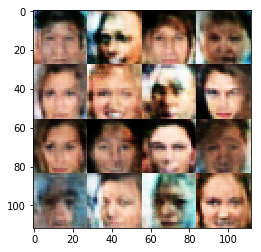

Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 2.1441
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 2.8323
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 1.8367
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7963


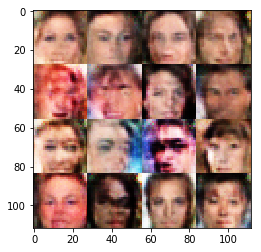

Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.4678
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.4251
Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 1.6140
Epoch 1/1... Discriminator Loss: 0.5840... Generator Loss: 2.8083
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 1.5761
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 5.9517
Epoch 1/1... Discriminator Loss: 1.6982... Generator Loss: 0.2345


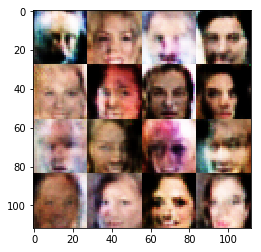

Epoch 1/1... Discriminator Loss: 0.4955... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 1.4428
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 0.3040... Generator Loss: 2.6897


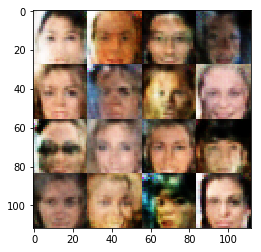

Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 1.6003
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.7686


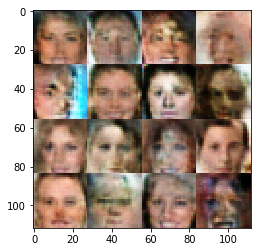

Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 0.5459... Generator Loss: 1.3632
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 1.8738
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 3.5597
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 2.6359
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 0.1505... Generator Loss: 4.0080
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.7427


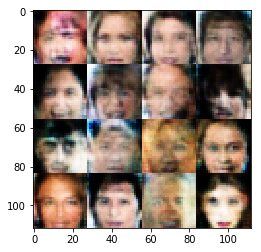

Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 0.4508... Generator Loss: 2.5055
Epoch 1/1... Discriminator Loss: 0.2228... Generator Loss: 3.5014
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.3434
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 3.0164
Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 3.7323
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 3.3875


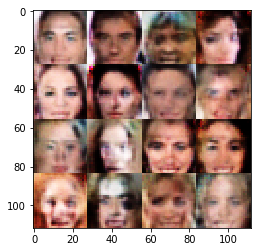

Epoch 1/1... Discriminator Loss: 0.3587... Generator Loss: 2.1202
Epoch 1/1... Discriminator Loss: 0.0885... Generator Loss: 3.4710
Epoch 1/1... Discriminator Loss: 6.0580... Generator Loss: 6.8236
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.8951


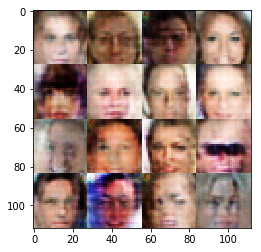

Epoch 1/1... Discriminator Loss: 1.7764... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.6831


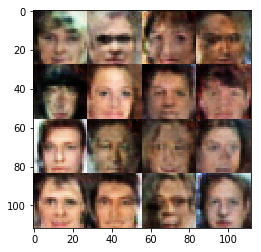

Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 1.1601
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7558


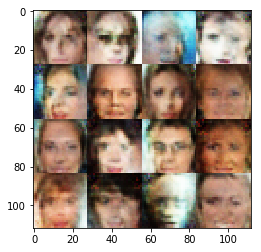

Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.7958


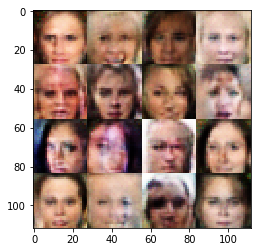

Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.4883


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
keep_prob = 1.0


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, keep_prob)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.